In [45]:
#Equação de Schrondinger para duas partículas

#Danilo Lessa Bernardineli
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

In [46]:
### Parâmetros das condições iniciais ###
#Particula 1
params_x = {"x_c": 0.1, "s": 0.05, "k_0": 30.0, "m": 1.0}
mx = 1.0

#Particula 2
params_y = {"x_c": -0.1, "s": 0.05, "k_0": -30.0, "m": 1.0}
my = 1.0

#Parâmetros do potencial barreira
V_0 = 1000
alfa = 1

def V(r):
    return 0
    return V_0 * np.exp(-alfa * r)

In [47]:
### Parâmetros de simulação ###

#Intervalo no eixo x
x_i = -1
x_f = 1

#Intervalo temporal
t_0 = 0
t_f = 0.05

#Passos
dt = 0.0001
r = 0.075
dx = np.sqrt(dt / (2 * r))
dx2 = dx ** 2

#Tamanho das matrizes de simulação
Nt = int((t_f - t_0) / dt)
Nx = int((x_f - x_i) / dx)

#Discretização do espaço contínuo
Td = np.arange(Nt, dtype=np.int)
Xd = np.arange(Nx, dtype=np.int)
e = 1e-7
Yd = np.arange(Nx, dtype=np.int)

#Representação no espaço contínuo
T = Td * dt
X = (Xd * dx) + x_i
Y = (Yd * dx) + x_i + dx/2

In [48]:
def waveFunction(x, params):
    """Initial time-indepedent wavefunction.
    Keyword arguments:
    x -- Wavefunction on the x position
    """
    x_c = params["x_c"]
    k_0 = params["k_0"]
    s = params["s"]
    
    expoent = (-1/2) * (((x - x_c) / s)) ** 2
    return np.exp(1j * k_0 * x) * np.sqrt(np.exp(expoent) / (s * np.sqrt(2 * np.pi)))


def der_A(A, i):
    if (i == 0):
        return (A[i+1] - 2 * A[i]) / dx2
    elif i == Nx - 1:
        return (-2 * A[i] + A[i-1]) / dx2
    else:
        return (A[i+1] - 2 * A[i] + A[i-1]) / dx2

def der_X(Wk, i, j):
    return der_A(Wk[:, j], i)

def der_Y(Wk, i, j):
    return der_A(Wk[i, :], j)

def der_RK(Wk, i, j, sign):
    x = X[i]
    y = Y[j]
    r = np.abs(x - y)
    
    Axx = der_X(Wk, i, j)
    Ayy = der_Y(Wk, i, j)
    VA = V(r) * Wk[i, j]
    #VA = 0

    return sign * ((Axx / mx + Ayy / my) / 2 - VA)
    
def der_W(Wk, i, j):
    R = np.real(Wk)
    I = np.imag(Wk)
    return der_RK(I, i, j, -1) + 1j * der_RK(R, i, j, 1)

def get_H(Wk, i, j):
    R = np.real(Wk)
    I = np.imag(Wk)
    return der_RK(R, i, j, -1) + 1j * der_RK(I, i, j, -1)

In [49]:
W = np.zeros((Nx, Nx, Nt), dtype=np.complex_)
Wconj = np.zeros((Nx, Nx, Nt), dtype=np.complex_)
H = np.zeros((Nx, Nx, Nt), dtype=np.complex_)

Wabs = np.zeros((Nx, Nx, Nt))
Px = np.zeros((Nx, Nt))
Py = np.zeros((Nx, Nt))

N = np.zeros(Nt)
E = np.zeros(Nt, dtype=np.complex_)

def post_process(k, W, H, E, N, Wconj, Wabs, Px, Py):   
  
    Wk = W[:, :, k]
    Wconj[:, :, k] = np.conj(Wk)
    Wabs[:, :, k] = np.abs(Wk)
    N[k] = np.sum(Wabs[:, :, k] ** 2 * dx2)
    
    for i in Xd:
        for j in Yd:
            Wijk = W[i, j, k]
            H[i, j, k] = get_H(Wk, i, j)
            Px[i, k] += Wabs[i, j, k] ** 2 * dx
            Py[j, k] += Wabs[i, j, k] ** 2 * dx
            
    E[k] = np.sum(Wconj[:, :, k] * H[:, :, k] * dx2) / N[k]    

In [50]:
for k in Td:
    print("%s/%s" %(k, Nt))
    t = T[k]
    
    if k == 0:
        for i in Xd:
            x = X[i]
            for j in Yd:
                y = Y[j]
                Wijk = waveFunction(x, params_x) * waveFunction(y, params_y)
                W[i, j, k] = Wijk
    else:
        Wk = W[:, :, k-1]
        half_Wk = np.zeros((Nx, Nx), dtype=np.complex_)

        #Primeira parte do RK2
        for i in Xd:
            x = X[i]        
            for j in Yd:
                y = Y[j]
                
                #
                Wijk = W[i, j, k-1]

                #Derivada total
                k1 = der_W(Wk, i, j) * dt

                #Aproximação
                half_Wk[i, j] = Wijk + k1 / 2


        #Segunda parte do RK2
        for i in Xd:
            x = X[i]        
            for j in Yd:
                y = Y[j]

                Wijk = half_Wk[i, j]

                #Derivada no meio passo
                k2 = der_W(Wk, i, j) * dt

                #Aproximação final
                Wijk = Wijk + k2
                W[i, j, k] = Wijk

    post_process(k, W, H, E, N, Wconj, Wabs, Px, Py)            

0/500
1/500
2/500
3/500
4/500
5/500
6/500
7/500
8/500
9/500
10/500
11/500
12/500
13/500
14/500
15/500
16/500
17/500
18/500
19/500
20/500
21/500
22/500
23/500
24/500
25/500
26/500
27/500
28/500
29/500
30/500
31/500
32/500
33/500
34/500
35/500
36/500
37/500
38/500
39/500
40/500
41/500
42/500
43/500
44/500
45/500
46/500
47/500
48/500
49/500
50/500
51/500
52/500
53/500
54/500
55/500
56/500
57/500
58/500
59/500
60/500
61/500
62/500
63/500
64/500
65/500
66/500
67/500
68/500
69/500
70/500
71/500
72/500
73/500
74/500
75/500
76/500
77/500
78/500
79/500
80/500
81/500
82/500
83/500
84/500
85/500
86/500
87/500
88/500
89/500
90/500
91/500
92/500
93/500
94/500
95/500
96/500
97/500
98/500
99/500
100/500
101/500
102/500
103/500
104/500
105/500
106/500
107/500
108/500
109/500
110/500
111/500
112/500
113/500
114/500
115/500
116/500
117/500
118/500
119/500
120/500
121/500
122/500
123/500
124/500
125/500
126/500
127/500
128/500
129/500
130/500
131/500
132/500
133/500
134/500
135/500
136/500
137/500
138/50

In [51]:
def plot_interactive(k):
    plt.plot(X, Px[:, k], 'b', label="$|\phi_1(x_1)|^2$")
    plt.plot(Y, Py[:, k], 'r', label="$|\phi_2(x_2)|^2$")
    plt.suptitle("%s" % k)
    plt.title("Função de onda conjunta $\Psi(x_1, x_2, t)$")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("$P(x)^2$")

In [52]:
def plot_matrix(k):
    plt.subplot(311)
    plt.imshow(np.real(W[:, :, k]))
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    plt.subplot(312)
    plt.imshow(np.imag(W[:, :, k]))
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    plt.subplot(313)
    plt.imshow(np.abs(W[:, :, k]))    
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    plt.suptitle("%s" % k)

In [53]:
def make_movie(plot_f, fname):
    FFMpegWriter = manimation.writers['ffmpeg']
    writer = FFMpegWriter(fps=10)
    fig = plt.figure();
    with writer.saving(fig, fname, 200):
        for k in range(0, Nt-1):
            plot_f(k);
            writer.grab_frame();
            plt.clf();

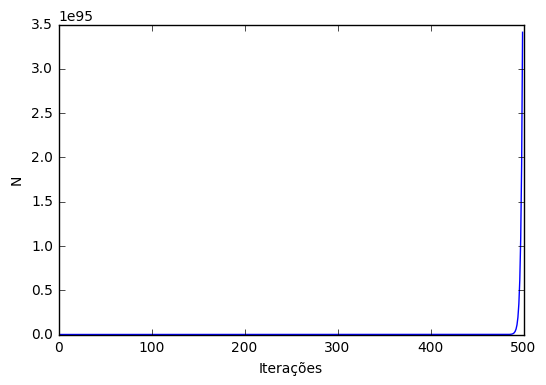

In [54]:
plt.plot(Td, N)
plt.xlabel("Iterações")
plt.ylabel("N")
plt.savefig("norma.png")
plt.show()

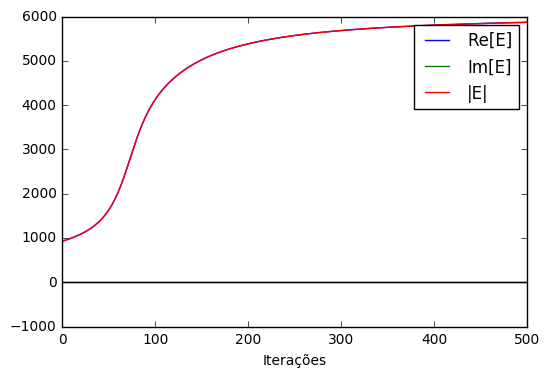

In [55]:
plt.plot(Td, np.real(E), label="Re[E]")
plt.plot(Td, np.imag(E), label="Im[E]")
plt.plot(Td, np.abs(E), label="|E|")
plt.plot(Td, np.zeros(len(Td)), '-k')
plt.legend()
plt.xlabel("Iterações")
plt.savefig("energia.png")
plt.show()

In [56]:
make_movie(plot_interactive, "interacao.mp4")

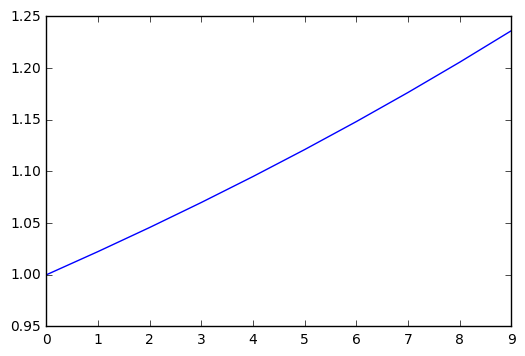

In [57]:
plt.plot(N[0:10])
plt.show()